In [1]:
! pip install scikit-learn matplotlib Pillow

In [2]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv
from sklearn.preprocessing import LabelEncoder
from scipy.stats import multivariate_normal
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import cv2
import math
import pickle
from sklearn.datasets import load_wine
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
label_encoder = LabelEncoder()

In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
dirpath = './IIIT-CFW/'
x,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


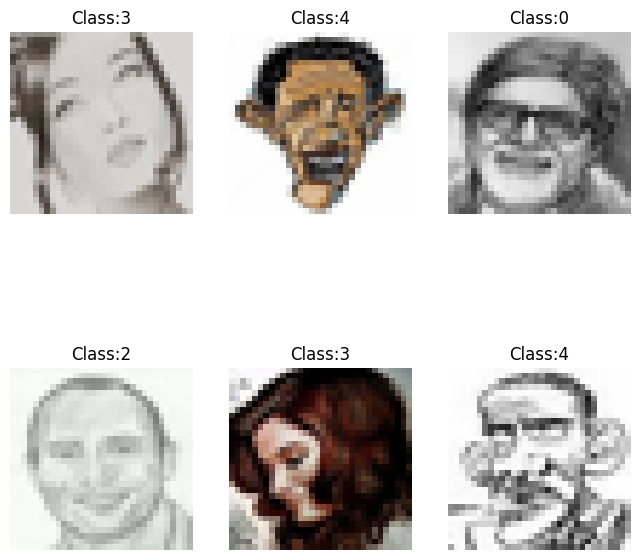

In [6]:
N,H,W = x.shape[0:3]
C = 1 if opt['is_grayscale'] else x.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(x[ind,...],y[ind], row=2,col=3)

In [7]:
def pca(x, y, k):
    x = x.reshape(x.shape[0], -1)
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    standadized_x = (x - mean) / std
    covariance_matrix = np.cov(standadized_x, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues = np.real(eigenvalues)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sum_eigenvalues = np.sum(sorted_eigenvalues)/100
    sorted_eigenvalues = sorted_eigenvalues / sum_eigenvalues
    final_eigenvectors = sorted_eigenvectors[:, :k]
    cumulative_explained_variance = []
    for i in range(0, k):
        cumulative_explained_variance.append(np.sum(sorted_eigenvalues[:i]))
    final_features = np.dot(final_eigenvectors.T, standadized_x.T).T
    return cumulative_explained_variance, final_features

In [8]:
number_of_pcs = np.arange(1, 672)
cumulative_explained_variances, principle_components = pca(x,y,671)

In [9]:
print((cumulative_explained_variances))

[0.0, 31.104285511964342, 40.03374303098917, 45.04856005469064, 48.03575151045708, 50.76772412903816, 53.13184915190614, 55.06289640958947, 56.74134875838266, 58.270265043575, 59.552172709276874, 60.68800453903075, 61.71430262344068, 62.675935127719974, 63.61814471932376, 64.49190268621885, 65.32970563161687, 66.09615865210706, 66.85540822326651, 67.55453980922512, 68.18492864911104, 68.8049018363168, 69.40608552609224, 69.95384728931725, 70.48422129909582, 71.0009907999465, 71.48549888644526, 71.95135733499121, 72.40399864397507, 72.84497994802474, 73.2756360836452, 73.69617413826407, 74.08625330975448, 74.47248188234973, 74.84249511287909, 75.20602531609863, 75.5591875286626, 75.90489695353996, 76.23910803711473, 76.56324848416357, 76.88053995687446, 77.1933035300369, 77.49491837410993, 77.78111264833724, 78.06442842829608, 78.3447784563279, 78.62051837927291, 78.88435953318147, 79.13764864545612, 79.3902275754748, 79.63597683561719, 79.87708408488436, 80.11230466413528, 80.341824703

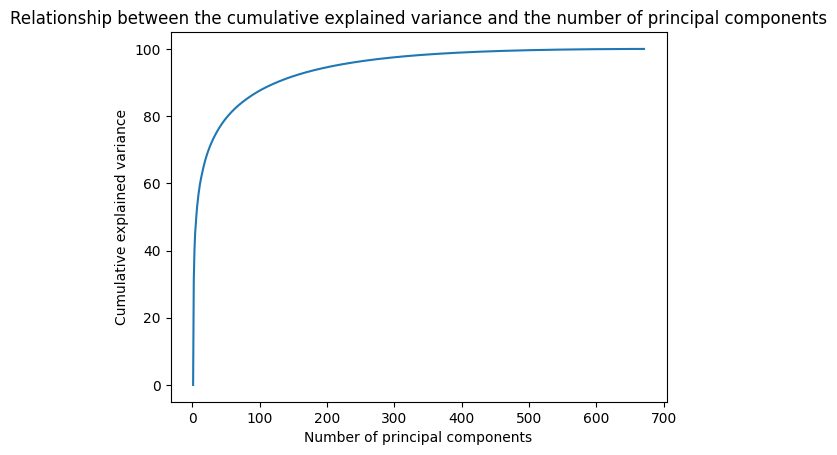

In [10]:
plt.plot(number_of_pcs, cumulative_explained_variances)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

In [11]:
data = np.load('data.npy', allow_pickle=True)
encoded_y = label_encoder.fit_transform(data[:, 3])
print(data[:, 3])
print(encoded_y)

['sleep' 'oven' 'chair' ... 'puppet' 'listen' 'exit']
[158 119  37 ... 136 109  67]


In [12]:
features = np.array([np.squeeze(element) for element in data[:, 2]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, encoded_y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.22


In [14]:
number_of_pcs = np.arange(1, 513)
accuracies_after = []
cumulative_explained_variances, principle_components = pca(features, data[:, 3], 512)
for i in range(1, 513):
    X_train, X_test, y_train, y_test = train_test_split(principle_components[:, :i], encoded_y, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies_after.append(accuracy)

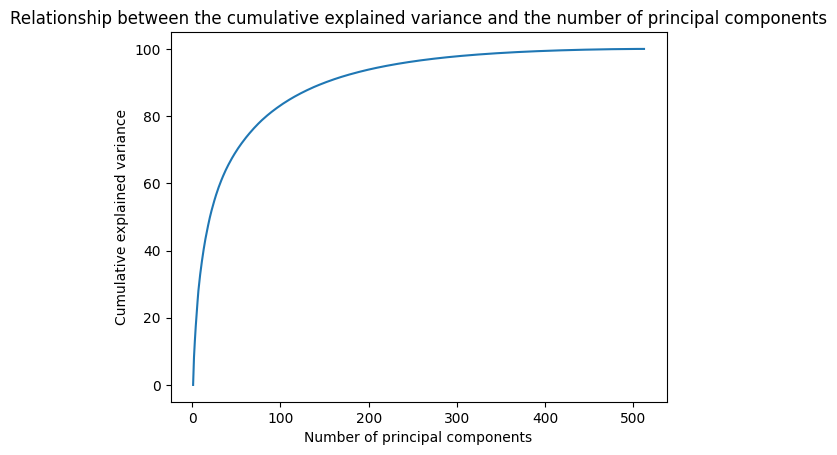

In [15]:
plt.plot(number_of_pcs, cumulative_explained_variances)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

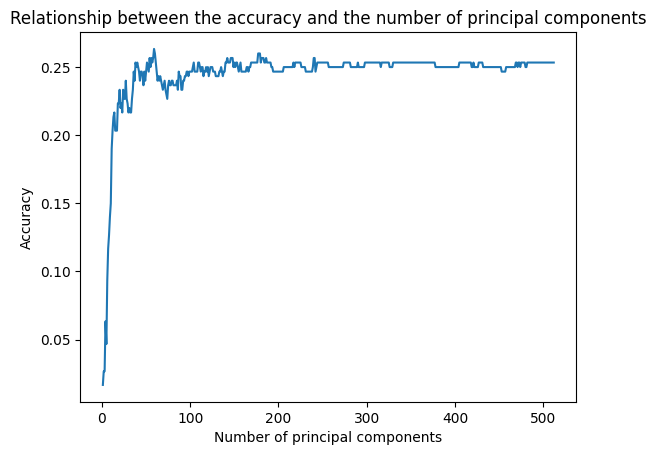

In [16]:
plt.plot(number_of_pcs, accuracies_after)
plt.xlabel("Number of principal components")
plt.ylabel("Accuracy")
plt.title("Relationship between the accuracy and the number of principal components")
plt.show()

In [17]:
csv_file_path = './smai_assignment_pictionary/drawer_attributes.csv'
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    data = []
    for row in csv_reader:
        data.append(row)
    data = data[1:]
    data = np.array(data)
    data = data.astype(float)
    print((data.shape))

(100, 9)


In [18]:
cumulative_explained_variances, principle_components = pca(data,[],2)
print(principle_components.shape)

(100, 2)


In [19]:
number_of_pcs = np.arange(0, 9)
cumulative_explained_variances, principle_components = pca(data,[],9)

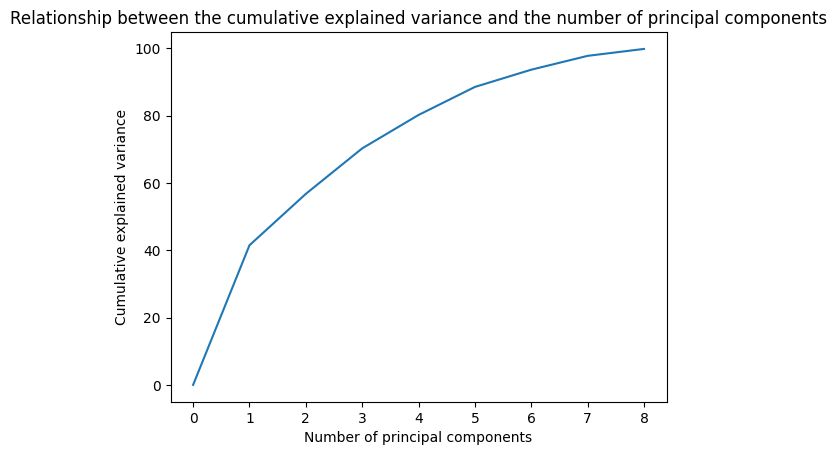

In [20]:
plt.plot(number_of_pcs, cumulative_explained_variances)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

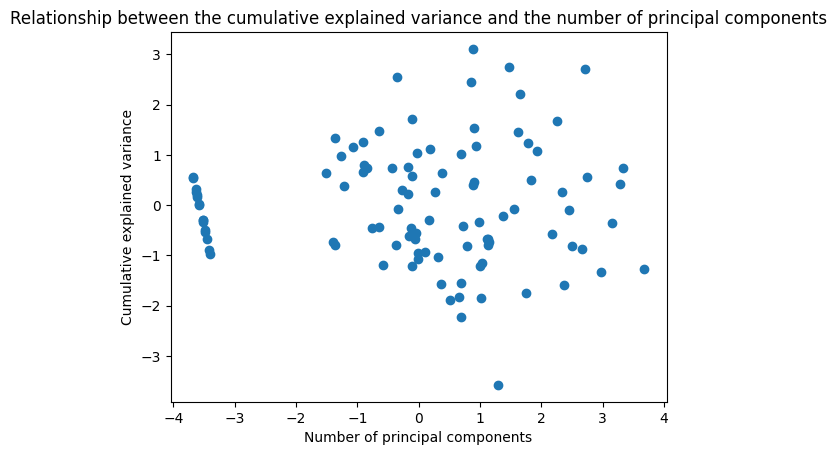

In [21]:
plt.scatter(principle_components[:, 0], principle_components[:, 1])
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

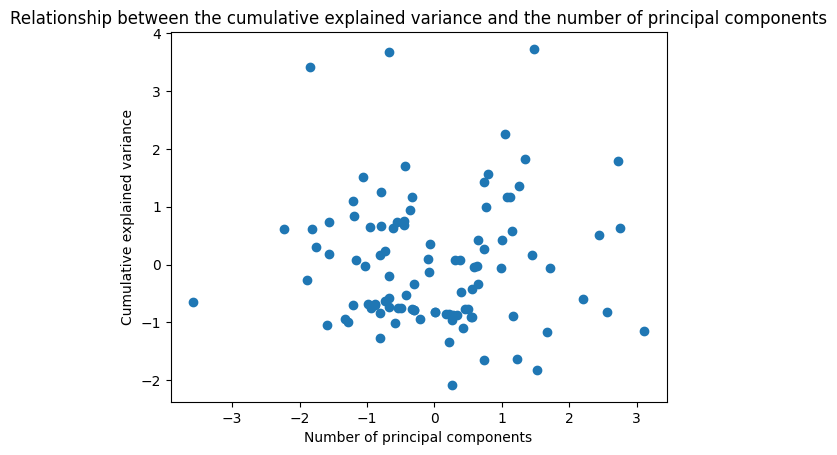

In [22]:
plt.scatter(principle_components[:, 1], principle_components[:, 2])
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

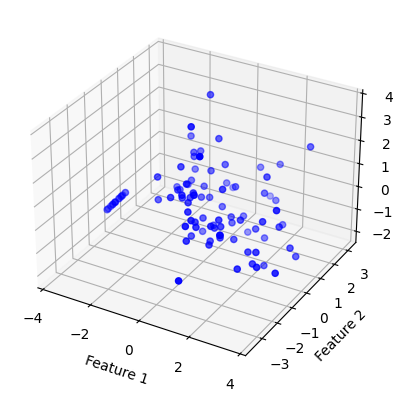

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principle_components[:, 0], principle_components[:, 1], principle_components[:, 2], c='b', marker='o')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

In [24]:
csv_file_path = './smai_assignment_pictionary/guesser_attributes.csv'
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    data = []
    for row in csv_reader:
        data.append(row)
    data = data[1:]
    data = np.array(data)
    data = data.astype(float)
    print((data.shape))

(100, 7)


In [25]:
cumulative_explained_variances, principle_components = pca(data,[],2)
print(principle_components.shape)

(100, 2)


In [26]:
number_of_pcs = np.arange(0, 7)
cumulative_explained_variances, principle_components = pca(data,[],7)

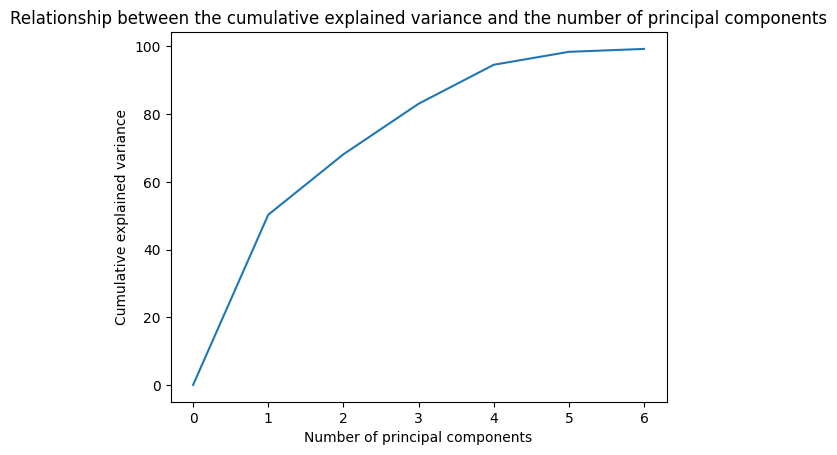

In [27]:
plt.plot(number_of_pcs, cumulative_explained_variances)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

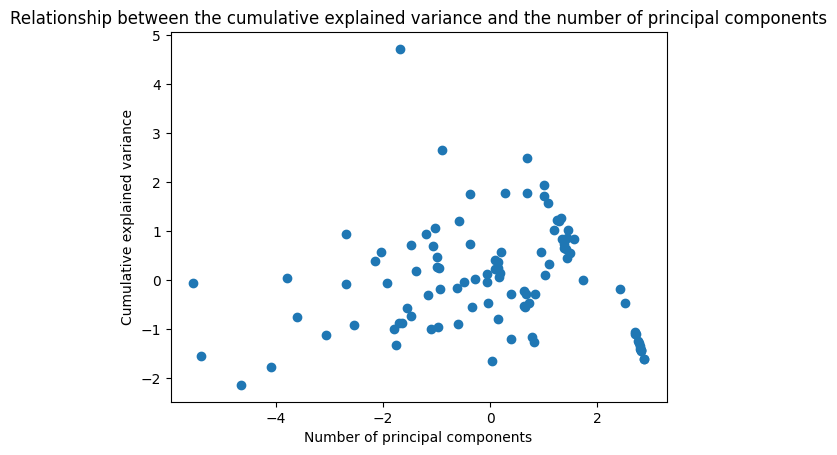

In [28]:
plt.scatter(principle_components[:, 0], principle_components[:, 1])
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

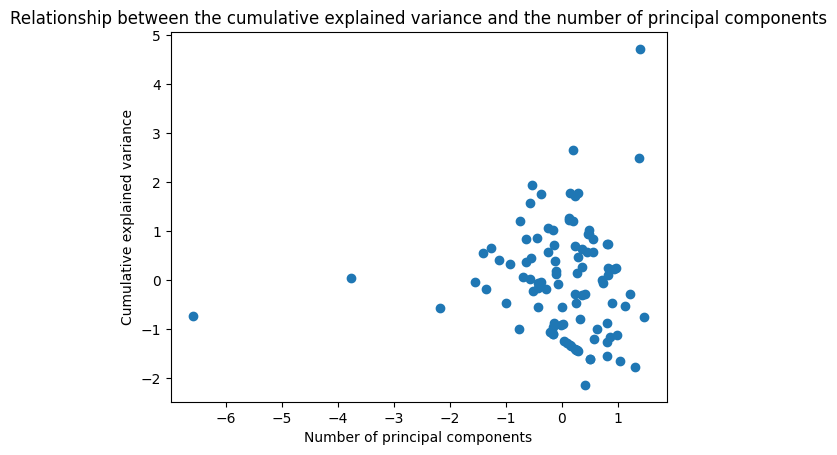

In [29]:
plt.scatter(principle_components[:, 2], principle_components[:, 1])
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Relationship between the cumulative explained variance and the number of principal components")
plt.show()

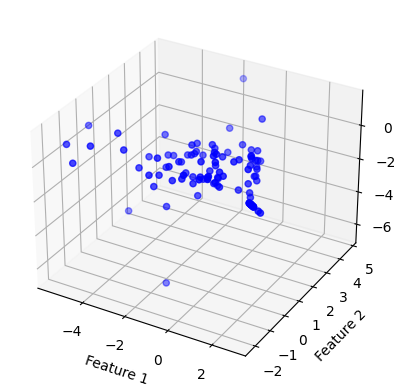

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principle_components[:, 0], principle_components[:, 1], principle_components[:, 2], c='b', marker='o')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()